In [1]:
import numpy as np

In [ ]:
data = np.load("../artifacts/glomerulo/embeddings_uni/embeddings_2025-04-16_04-16-09.npz", allow_pickle=True)

In [3]:
for i in data.keys():
    print(i)

db_embeddings
db_labels
db_path
query_embeddings
query_labels
query_classes
query_paths
class_mapping


In [17]:
folder_path = "../artifacts/glomerulo/embeddings_uni_fsl/embeddings_2025-04-20_15-19-51.npz"
data = np.load(folder_path, allow_pickle=True)

class_mapping = data['class_mapping'].item()

db_embeddings = data['db_embeddings']
db_paths = data['db_path']
db_labels = np.array([class_mapping[i] for i in data['db_labels']])

q_embeddings = data['query_embeddings']
q_paths = data['query_paths']
q_labels = np.array([f'q_{class_mapping[i]}' for i in data['query_labels']])
data_res = dict()



all_embeddings = np.vstack([db_embeddings, q_embeddings])
all_labels = np.concatenate([db_labels, q_labels])
all_paths = np.concatenate([db_paths, q_paths])


cm = {}
for label in all_labels:
    if label not in cm:
        cm[label] = label

data_res['db_embeddings'] = all_embeddings
data_res['db_path'] = all_paths
data_res['db_labels'] = all_labels
data_res['query_embeddings'] = all_embeddings
data_res['query_paths'] = all_paths
data_res['query_labels'] = all_labels
data_res['class_mapping'] = cm 


In [ ]:

np.savez('all_data_embeddings_uni_fsl.npz', **data_res)


{'Crescent': 'Crescent',
 'Hypercellularity': 'Hypercellularity',
 'Membranous': 'Membranous',
 'Normal': 'Normal',
 'Podocytopathy': 'Podocytopathy',
 'Sclerosis': 'Sclerosis',
 'q_Crescent': 'q_Crescent',
 'q_Hypercellularity': 'q_Hypercellularity',
 'q_Membranous': 'q_Membranous',
 'q_Normal': 'q_Normal',
 'q_Podocytopathy': 'q_Podocytopathy',
 'q_Sclerosis': 'q_Sclerosis'}

NameError: name 'query_labels' is not defined

In [1]:
import torch
import torch.nn.functional as F

# Um único embedding de suporte
support_embedding = torch.randn(1, 64)  # shape: [1, D]

# Queries
num_queries = 10
query_embeddings = torch.randn(num_queries, 64)  # shape: [Q, D]

# Calcula distância euclidiana
diff = query_embeddings - support_embedding  # broadcast: [Q, D]
dists = torch.sum(diff ** 2, dim=1)  # [Q]

# Converte a distância para uma "probabilidade" de pertencer à mesma classe
# Aqui, menor distância → maior similaridade
similarity = -dists  # ou usar exp(-dists)
probs = torch.sigmoid(similarity)  # valores entre 0 e 1

# Limite de decisão: 0.5 (pode ser ajustado)
preds = (probs > 0.5).long()

print("Probabilidades de pertencer à classe de suporte:\n", probs)
print("Predições (1 = pertence, 0 = não pertence):\n", preds)


Probabilidades de pertencer à classe de suporte:
 tensor([2.8024e-36, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.5411e-38, 0.0000e+00, 1.6838e-38, 0.0000e+00])
Predições (1 = pertence, 0 = não pertence):
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [38]:
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModel
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image

# Load an image
image = Image.open('./../../datasets/final/glomerulo/test/Crescent/Crescent 22-17-PAM.jpeg')

# Load phikon-v2
processor = AutoImageProcessor.from_pretrained("owkin/phikon-v2")
model = AutoModel.from_pretrained("owkin/phikon-v2")
model.eval()

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-23): 24 x Dinov2Layer(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_

In [ ]:


# Process the image
inputs = processor(image, return_tensors="pt")

# Get the features
with torch.inference_mode():
    outputs = model(**inputs)
    features = outputs.last_hidden_state[:, 0, :]  # (1, 1024) shape

assert features.shape == (1, 1024)


In [29]:
transform = A.Compose([
    A.SmallestMaxSize(max_size=224),  # Resize shortest edge to 224
    # A.CenterCrop(height=224, width=224),  # Center crop
    A.Normalize(  # Normalize with processor's mean and std
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        # max_pixel_value=255.0  # Equivalent to rescale by 1/255
    ),
    ToTensorV2(),  # Convert to PyTorch tensor
])
image_np = np.array(image)
processed = transform(image=image_np)
inputs2 = {"pixel_values": processed["image"].unsqueeze(0)} 

In [31]:
transform

Compose([
  SmallestMaxSize(p=1.0, max_size=224, max_size_hw=None, interpolation=1, mask_interpolation=0),
  Normalize(p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

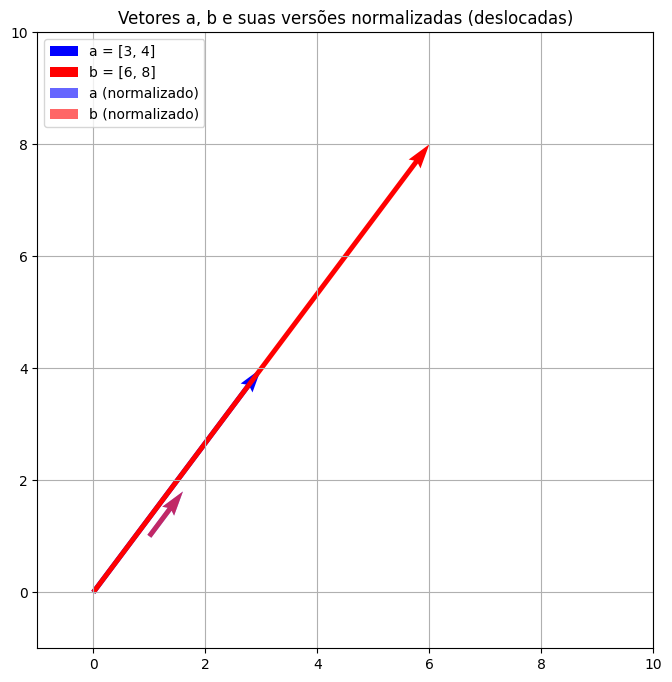

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Vetores
a = np.array([3, 4])
b = np.array([6, 8])  # múltiplo de a, mesma direção
a_norm = a / np.linalg.norm(a)
b_norm = b / np.linalg.norm(b)

# Distâncias e similaridade
euclidean_distance = np.linalg.norm(a - b)
cosine_similarity = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
euclidean_distance_normalized = np.linalg.norm(a_norm - b_norm)
cosine_similarity_normalized = np.dot(a_norm, b_norm)
# Corrigindo o erro de estilo e mantendo a clareza do gráfico
fig, ax = plt.subplots(figsize=(8, 8))

# Vetores originais
ax.quiver(0, 0, a[0], a[1], angles='xy', scale_units='xy', scale=1,
          color='blue', label='a = [3, 4]', width=0.008)
ax.quiver(0, 0, b[0], b[1], angles='xy', scale_units='xy', scale=1,
          color='red', label='b = [6, 8]', width=0.008)

# Vetores normalizados deslocados
offset_x, offset_y = 1.0, 1.0
ax.quiver(offset_x, offset_y, a_norm[0], a_norm[1], angles='xy', scale_units='xy', scale=1,
          color='blue', alpha=0.6, label='a (normalizado)', width=0.008)
ax.quiver(offset_x, offset_y, b_norm[0], b_norm[1], angles='xy', scale_units='xy', scale=1,
          color='red', alpha=0.6, label='b (normalizado)', width=0.008)

# Configurações do gráfico
ax.set_xlim(-1, 10)
ax.set_ylim(-1, 10)
ax.set_aspect('equal')
ax.grid(True)
ax.set_title('Vetores a, b e suas versões normalizadas (deslocadas)')
ax.legend(loc='upper left')

plt.show()


In [48]:
a

array([3, 4])

In [49]:
np.linalg.norm(a)

5.0

In [52]:
a_norm = a / np.linalg.norm(a)
a_norm

array([0.6, 0.8])

In [54]:
np.linalg.norm(a_norm)

1.0